In [108]:
# Importing the cv2 lib
import cv2

# OS traversal 
import os 

# Pytorch 
import torch

# ONNX models 
import onnx
import onnxruntime

# Predicting 
from tqdm import tqdm 

# Array math 
import numpy as np 

# Data wrangling 
import pandas as pd 

# Ploting 
import matplotlib.pyplot as plt

# Configuration reading 
import yaml 

# Typehinting 
from typing import Tuple

# Defining the path to model and video dirs 
model_dir = os.path.join(os.getcwd(), 'models')
video_dir = os.path.join(os.getcwd(), 'videos')

# Defining the directory for extracted images 
extracted_images_dir = os.path.join(os.getcwd(), 'extracted_images')
if not os.path.exists(extracted_images_dir):
    os.mkdir(extracted_images_dir)

# Postprocessed images 
postprocessed_images_dir = os.path.join(os.getcwd(), 'postprocessed_images')
if not os.path.exists(postprocessed_images_dir):
    os.mkdir(postprocessed_images_dir)

In [109]:
# Reading the configuration 
with open('configuration.yml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# Loading the model name 
model_name = config['MODEL_TO_USE_WALDO']

# Loading the video to blurr 
video_name = config['VIDEO_TO_USE']

# Defining the paths to the model and video
model_path = os.path.join(model_dir, model_name)
video_path = os.path.join(video_dir, video_name)

In [110]:
def infer_img_size_from_name(x: str) -> Tuple: 
    """
    Infers the size of the image from the square model name 
    """
    # Spliting by - 
    x = x.split('-')

    # Leaving the entry that has <int>px pattern in it 
    x = [i for i in x if 'px' in i][0]

    # Removing the px
    x = x.replace('px', '')

    # Converting to int 
    x = int(x)

    # Returning a tuple 
    return (x, x)

In [111]:
# Saving the image size
w, h = infer_img_size_from_name(model_name)

# Printing the size 
print(f'Image size: {w}x{h}')

Image size: 1088x1088


In [112]:
# Loading the onnx model 
model = onnx.load(model_path)

# Checking the model 
onnx.checker.check_model(model)

# Defining the class dictionary 

In [113]:
classes = config['WALDO_CLASSES']

# Creating a classes dictionary 
classes_dict = dict()
for i, c in enumerate(classes):
    classes_dict[i] = c

# Extracting the steps to do 

In [114]:
steps = config['STEPS']

# Splitting the video into images 

In [115]:
split_img = steps['SPLIT_VIDEO']

# Empty placeholder for the split_images_dir 
split_images_dir = None

if split_img:
    # Reading the video 
    cap = cv2.VideoCapture(video_path)

    # Saving the number of frames 
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Creating the path for the split images 
    split_images_dir = os.path.join(extracted_images_dir, video_name)

    # Creating a dir if not exists; Else, removing all the images
    if not os.path.exists(split_images_dir):
        os.makedirs(split_images_dir, exist_ok=True)
    else:
        for image in os.listdir(split_images_dir):
            os.remove(os.path.join(split_images_dir, image))

    # Spliting the video by frame 
    for i in tqdm(range(n_frames), desc='Spliting the video'):
        ret, frame = cap.read()
        if ret == False:
            break
        cv2.imwrite(os.path.join(split_images_dir, f'{str(i)}.jpg'), frame)
else:
    split_images_dir = os.path.join(extracted_images_dir, video_name)

Spliting the video: 100%|██████████| 4996/4996 [01:15<00:00, 65.98it/s]


# Blurring the images 

In [116]:
# Defining the classes to plot 
classes_to_plot = config['WALDO_CLASSES_PLOT']

# Defining the classes to blurr 
classes_to_blurr = config['WALDO_CLASSES_BLURR']

In [117]:
def letterbox(im, new_shape=(960, 960), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

## Example image pipeline 

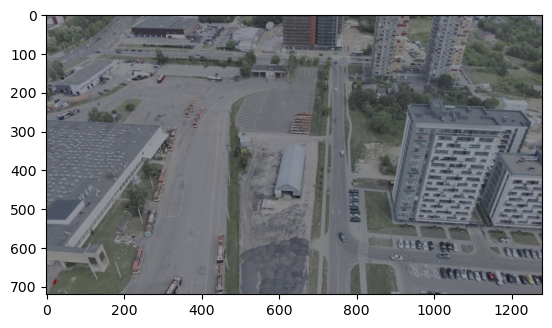

In [118]:
if split_images_dir is not None:

    # Getting one image path 
    image_path = os.path.join(split_images_dir, os.listdir(split_images_dir)[0])

    # Reading the image from open cv 
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

    # Saving the original image's w and h 
    original_w, original_h = image.shape[1], image.shape[0]

    # Ploting the image 
    plt.imshow(image)

In [119]:
# Reshaping the image to w and h resolution 
img, ratio, dwdh = letterbox(image, new_shape=(h, w), auto=False, color=(0, 0, 0))

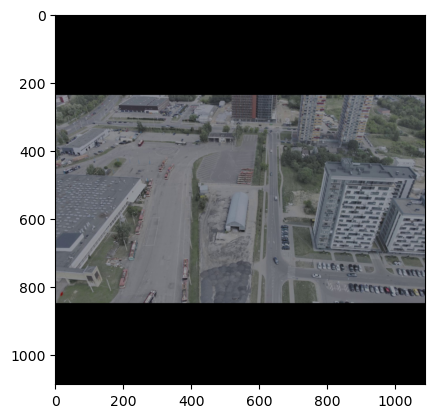

In [120]:
plt.imshow(img)

In [121]:
# Preparing the input for the deep learning model
img = img.transpose((2, 0, 1))
img = np.expand_dims(img, 0)
img = np.ascontiguousarray(img)

img = img.astype(np.float32)
img /= 255

In [122]:
# Starting the session 
cuda = torch.cuda.is_available()

# Initialize ONNX runtime session with CUDA execution
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if cuda else ['CPUExecutionProvider']

# Initiating the onnx runtime 
ort_session = onnxruntime.InferenceSession(model_path, providers=providers)

In [123]:
# Predicting 
ort_inputs = {ort_session.get_inputs()[0].name: img}
ort_outs = ort_session.run(None, ort_inputs)

# Getting the bounding boxes
list_of_objects = []
if len(ort_outs) > 0:
    boxes = ort_outs[0] 

    print(f"Number of objects: {len(boxes)}")

    # Iterating over the boxes
    for box in boxes:
        # The box is a list with the following coordinates: 
        # (batch_id, x0, y0, x1, y1, cls_id, score)

        # Getting the class id
        class_id = int(box[5])

        # Getting the class name
        class_name = classes_dict[class_id]

        # Only leaving the classes to plot
        if class_name not in classes_to_plot:
            continue

        # Getting the x, y, w, h
        x0, y0, x1, y1 = box[1], box[2], box[3], box[4]

        # Transforming the coords 
        bbox = np.array([x0, y0, x1, y1])
        bbox -= np.array(dwdh * 2)
        bbox /= ratio
        bbox = bbox.round().astype(np.int32).tolist()

        # Extracting the prediction score 
        score = box[6]

        # Creating an entry for the list 
        list_of_objects.append({
            'class_id': class_id, 
            'class_name': class_name, 
            'x0': bbox[0], 
            'y0': bbox[1], 
            'x1': bbox[2], 
            'y1': bbox[3], 
            'score': round(float(score), 2)
        })

print(f"The number of objects to plot: {len(list_of_objects)}")

Number of objects: 104
The number of objects to plot: 77


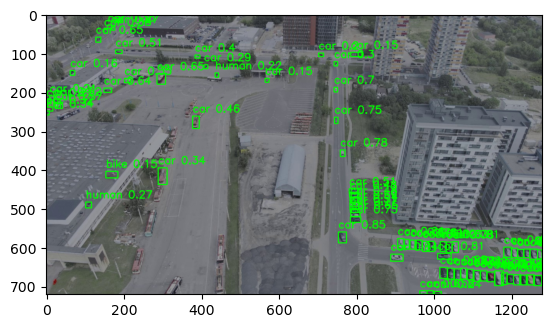

In [124]:
# Reading and plotting the original image
img = image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

# Plotting the bounding boxes
for obj in list_of_objects:
    # Getting the image shape
    h_, w_, _ = img.shape

    # Iterating over the rows
    for entry in list_of_objects:
        # Getting the class name
        class_name = entry['class_name']

        # Extracting the score
        score = entry['score']

        # Getting the coordinates
        x0, y0, x1, y1 = int(entry['x0']), int(entry['y0']), int(entry['x1']), int(entry['y1'])

        # Drawing the rectangle
        cv2.rectangle(img, (x0, y0), (x1, y1), (0, 255, 0), 2)

        # Putting the class name
        cv2.putText(img, f"{class_name} {score}", (x0, y0 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Plotting the image
plt.imshow(img)

# Applying on all images 

In [125]:
# Extracting the number of frames to plot 
n_frames_to_plot = config.get('FRAMES_TO_PLOT', 100)

In [126]:
cuda = torch.cuda.is_available()

# Initialize ONNX runtime session with CUDA execution
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if cuda else ['CPUExecutionProvider']

# Initiating the onnx runtime 
ort_session = onnxruntime.InferenceSession(model_path, providers=providers)

# Listing the images in the extracted images dir
images = os.listdir(split_images_dir)

# Creating the image dictionary where the key is the image name and the image index 
image_dict = dict()
for image in images:
    image_dict[image] = int(image.split('.')[0])

# Sorting the images by the index
images = sorted(images, key=lambda x: image_dict[x])

if n_frames_to_plot is not None:
    # Getting the first n frames 
    images = images[:n_frames_to_plot]

# Iterating over the images
list_of_images = []
for image in tqdm(images):
    # Predicting the bounding boxes
    img = cv2.cvtColor(cv2.imread(os.path.join(split_images_dir, image)), cv2.COLOR_BGR2RGB)

    # Preprocesing
    img, ratio, dwdh = letterbox(img, new_shape=(h, w), auto=False, color=(0, 0, 0))

    # Creating input for the model
    img = img.transpose((2, 0, 1))
    img = np.expand_dims(img, 0)
    img = np.ascontiguousarray(img)

    img = img.astype(np.float32)
    img /= 255

    # Predicting the bounding boxes
    ort_inputs = {ort_session.get_inputs()[0].name: img}
    ort_outs = ort_session.run(None, ort_inputs)

    # Getting the bounding boxes
    if len(ort_outs) > 0:
        boxes = ort_outs[0] 

        # Iterating over the boxes
        for box in boxes:
            # The box is a list with the following coordinates: 
            # (batch_id, x0, y0, x1, y1, cls_id, score)

            # Getting the class id
            class_id = int(box[5])

            # Getting the class name
            class_name = classes_dict[class_id]

            # Only leaving the classes to plot
            if class_name not in classes_to_plot:
                continue

            # Getting the x, y, w, h
            x0, y0, x1, y1 = box[1], box[2], box[3], box[4]

            # Transforming the coords 
            bbox = np.array([x0, y0, x1, y1])
            bbox -= np.array(dwdh * 2)
            bbox /= ratio
            bbox = bbox.round().astype(np.int32).tolist()

            # Extracting the prediction score 
            score = box[6]

            # Creating an entry for the list 
            list_of_images.append({
                'image_path': os.path.join(split_images_dir, image),
                'base_image': image,
                'class_id': class_id, 
                'class_name': class_name, 
                'x0': bbox[0], 
                'y0': bbox[1], 
                'x1': bbox[2], 
                'y1': bbox[3], 
                'score': round(float(score), 2)
            })

# Creating an prediction dataframe 
df = pd.DataFrame(list_of_images)

# Sorting by image name 
df = df.sort_values(by=['image_path'])

100%|██████████| 500/500 [07:36<00:00,  1.09it/s]


# Drawing the bounding boxes and blurring 

In [127]:
# Creating the output dir 
postprocessed_images_dir_video = os.path.join(postprocessed_images_dir, video_name)
if not os.path.exists(postprocessed_images_dir_video):
    os.mkdir(postprocessed_images_dir_video)

# Iterating over the images
for image_path in tqdm(df['image_path'].unique()):
    # Subsetting the dataframe
    df_subset = df[df['image_path'] == image_path].copy()

    # Reading the image
    img = cv2.imread(image_path)

    # Iterating over the rows
    for _, row in df_subset.iterrows():
        try:
            # Getting the class name
            class_name = row['class_name']

            # Extracting the score
            score = row['score']

            # Getting the coordinates
            x0, y0, x1, y1 = int(row['x0']), int(row['y0']), int(row['x1']), int(row['y1'])

            # Drawing the rectangle
            cv2.rectangle(img, (x0, y0), (x1, y1), (0, 255, 0), 2)

            # Putting the class name
            cv2.putText(img, f"{class_name} {score}", (x0, y0 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

            # If the class name is in the classes to blurr, blurr the image
            if class_name in classes_to_blurr:
                # Blurring the image
                img[y0:y1, x0:x1] = cv2.blur(img[y0:y1, x0:x1], (30, 30))
        except Exception as e:
            print(e)

    # Defining the path to the image
    image_path = os.path.join(postprocessed_images_dir_video, os.path.basename(image_path))

    # If the image exists in the postprocessed images dir, remove it
    if os.path.exists(image_path):
        os.remove(image_path)

    # Saving the image
    cv2.imwrite(image_path, img)

100%|██████████| 500/500 [00:15<00:00, 32.62it/s]


# Making a video from the images

In [128]:
# Converting all the images in the postprocessed images dir to a video
images = os.listdir(postprocessed_images_dir_video)

# Creating the image dictionary where the key is the image name and the image index 
image_dict = dict()
for image in images:
    image_dict[image] = int(image.split('.')[0])

# Sorting the images by the index
images = sorted(images, key=lambda x: image_dict[x])

# Creating the output directory 
output_dir = os.path.join(os.getcwd(), 'output', video_name)
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

# Defining the output video path
output_video_path = os.path.join(output_dir, 'output_video.mp4')

# Defining the fps
fps = 24

# Defining the size of the video
# Reading the first image to get the sizes 
img = cv2.imread(os.path.join(postprocessed_images_dir_video, images[0]))
size = (img.shape[1], img.shape[0])

# Defining the video writer
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

# Iterating over the images
for image in tqdm(images):
    # Reading the image
    img = cv2.imread(os.path.join(postprocessed_images_dir_video, image))

    # Writing the image
    out.write(img)

cv2.destroyAllWindows()

# Closing the video writer
out.release()

100%|██████████| 500/500 [00:08<00:00, 57.37it/s]
